In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuroPixel
from sklearn.cluster import DBSCAN

%matplotlib inline

In [2]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

user = "Cole"

if user == "Hennig":
    data_path = '/disk/scratch/mhennig/neuropixel/data/rawDataSample.bin'
elif user == "Martino":
    data_path = "data/rawDataSample.bin"
else:
    data_path = '/home/cole/neuropixeldata/rawDataSample.bin'

to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 12
file_name = 'ProcessedSpikes'


In [3]:
Probe = NeuroPixel(fps=30000, data_file_path=data_path)

H = herdingspikes(Probe)

In [4]:
H.DetectFromRaw(to_localize,file_name, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0)

# # OR

# H.LoadDetected()

# Sampling rate: 30000
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 100000
# Analysing 100000 frames; -42 100055
# Analysing 100000 frames; 99958 200055
# Analysing 100000 frames; 199958 300055
# Analysing 100000 frames; 299958 400055
# Analysing 100000 frames; 399958 500055
# Analysing 100000 frames; 499958 600055
# Analysing 100000 frames; 599958 700055
# Analysing 100000 frames; 699958 800055
# Analysing 100000 frames; 799958 900055
# Analysing 100000 frames; 899958 1000055
# Analysing 100000 frames; 999958 1100055
# Analysing 100000 frames; 1099958 1200055
# Analysing 100000 frames; 1199958 1300055
# Analysing 100000 frames; 1299958 1400055
# Analysing 100000 frames; 1399958 1500055
# Analysing 100000 frames; 1499958 1600055
# Analysing 100000 frames; 1599958 1700055
# Analysing 99945 frames; 1699958 1800000
# Time taken for detection: 0:00:14.819834
# Time 

Spike detected at channel:  338
Spike detected at frame:  15533


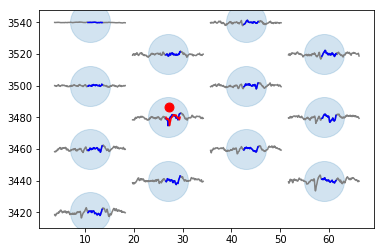

In [37]:
#plt.figure(figsize=(20,10))
H.PlotTracesChannels(data_path, 3025)

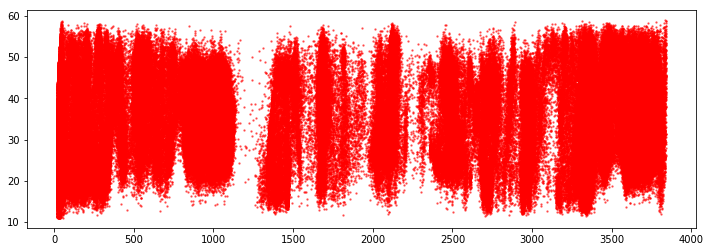

In [6]:
plt.figure(figsize=(12, 4))
H.PlotAll(invert=True, s=2, alpha=0.5)

In [7]:
H.CombinedClustering(alpha=40,
                    bandwidth=20, bin_seeding=True, min_bin_freq=10,
                    pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

/home/cole/spike_sorting_neuropixel/hs2.py:212: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.spikes.cl = clusterer.labels_


Number of estimated clusters: 190


In [14]:
H.fourvec.size

1541060

In [15]:
H.centerz

array([[  3.78966044e+01,   1.68073683e+03,  -2.56936504e+01,
          8.69274823e+00],
       [  2.84783573e+01,   2.68791617e+03,  -2.00587772e+01,
          2.99597499e+00],
       [  4.11619437e+01,   2.12253432e+03,  -2.48564848e+01,
          8.47507550e+00],
       [  2.78607173e+01,   2.99263659e+03,  -3.32878530e+01,
         -1.30265838e+01],
       [  3.66647841e+01,   8.31554711e+02,  -3.33568503e+01,
         -8.68160967e-01],
       [  2.86026265e+01,   1.35697055e+03,  -1.96927113e+01,
         -1.46801480e+01],
       [  3.57158856e+01,   1.70870268e+03,   5.00592357e+01,
         -3.19177220e+01],
       [  3.66487674e+01,   2.77285058e+03,  -3.53938425e+01,
          5.09907827e+00],
       [  2.72874669e+01,   2.94407721e+03,  -3.39781857e+01,
          5.60619901e-01],
       [  3.35022864e+01,   3.59609573e+03,  -2.87646130e+01,
         -1.81410274e+00],
       [  3.62018097e+01,   3.41052029e+03,   1.19271289e+01,
          5.50396315e+01],
       [  4.44665980e

In [ ]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=10)
plt.xlim((1350,1600))
plt.title("MeanShift, bandwidth=20, min_bin_freq=10")

In [ ]:
H.CombinedClustering(eps=8, alpha=40, clustering_algorithm=DBSCAN,
                    min_samples=5, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

In [ ]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=8)
plt.title("DBSCAN eps=8, min_samples=5")
plt.xlim((1350,1600))


In [ ]:
units = (121,4)

H.PlotShapes(units)